# Kinetics IV

[What is Bond listening to right now?](https://www.youtube.com/watch?v=w2MgsxiHd7s&list=RDw2MgsxiHd7s&start_radio=1)

This Notebook continues with the analysis of kinetic data obtained in a constant volume batch reactor. Now that we have a basic understanding of the methods (least squares minimization, linearization, linear regression, etc.), we will work through noisy data (i.e., real data). We will introduce a few concepts and techniques for managing noisy data, and we will consider the method of excess, which can be useful for determining reaction orders on individual reactants for reactions that involve multiple reactants. We will again leverage various statistical metrics that complement the residual sum of squares to help quantify goodness of fit; these include the coefficient of determination, $R^2$, and confidence intervals on parameter estimates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

The following reaction is carried out in a well-mixed, constant volume batch reactor. The concentration of species $A$ and $B$ in the tank are initially $C_{A0} = 0.05 \ \mathrm{M}$ and $C_{B0} = 0.5 \ \mathrm{M}$, respectively. The fluid inside of the reactor has constant density. 
	
$$A + B \longrightarrow C$$

You measure the concentration of species $A$ in this reactor, monitoring how it changes with time. The data you collect are given in the table below. 

| time (min) | $C_A \times 10^{2} \ (\mathrm{mol \ L^{-1}})$ |
|:----------:|:---------------------------------------------:|
|0           | 4.81                                          |
|25          | 4.52                                          |
|50          | 3.86                                          |
|75          | 3.30                                          |
|100         | 3.21                                          |
|125         | 2.73                                          |
|150         | 2.53                                          |
|175         | 2.43                                          |
|200         | 2.31                                          |
|225         | 2.01                                          |
|250         | 1.96                                          |
|275         | 1.88                                          |
|300         | 1.70                                          |

You may assume that the rate law is described by power law kinetics,

$$r = k{C_A}^{\alpha}{C_B}^{\beta}$$

where $\alpha$ is an ***unknown integer*** and $\beta = 1$. Determine the reaction order in $A$, $\alpha$, and the rate constant for this reaction.

### Solution to Example Problem 01

Before we start, it's important to point out something about regression and parameter estimation.  Here, we are looking for the order with respect to species $A$. If we're trying to extract that order from data, it is easiest to do if we've performed an experiment ***where we are only varying the concentration of species $A$ and watching how the system responds***. If the concentration of $B$ also varies, this generally will impact the reaction rate, so it is difficult for us to isolate the relationship between $r$ and $C_A$. In a batch reactor, it can be tricky to hold the concentration of one reactant constant while varying the other because both species are consumed in the reaction, and there is no avoiding the fact that the concentrations of species $A$ and species $B$ will both change as a function of time.

One was to handle this is by performing the experiment in such a way that the only the concentration of interest varies ***significantly*** (in this case, species A) while the other remains ***approximately constant***. This is commonly known as the ***method of excess***. It entails having one reactant present in a large excess so that its concentration does not ***significantly change*** over the course of the experiment.  Here, that is done with species $B$. Its initial concentration is 0.5M, whereas the initial concentration of $A$ is $C_{A0} = 0.05 \ \mathrm{M}$. Clearly, species $A$ is the limiting reactant! We can calculate that even if we convert 100% of species $A$, concentration of species $B$ will only decrease 10% to $C_B = 0.45 \ \mathrm{M}$. A 10% change in the concentration of species $B$ alongside a 100% change in the concentration of species $A$ is relatively insignificant, and it will not meaningfully impact our estimates of reaction rate. This allows us to extract the dependence on species A from our data.

We can simplify the rate law to account for an approximately constant concentration of $B$. This is not necessary, but it makes the symbolic manipulations a bit cleaner. We start with the general rate expression:

$$r = k{C_A}^\alpha{C_B}^\beta$$

We know that $\beta$ = 1, so:

$$r = k{C_A}^\alpha{C_B}$$

Since in this experiment $C_B \approx C_{B0}$:

$$r = k{C_A}^\alpha{C_{B0}}$$

Since $C_{B0}$ is constant, we lump it it with the rate constant to get:

$$r = k^\prime{C_A}^\alpha$$

This is a rate expression that only depends on the concentration of $A$. We just have to remain mindful that the rate constant we estimate from this model, $k^\prime$ is actually defined as:

$$k^\prime = kC_{B0}$$

So if we want to get the true rate constant, $k$, we have to account for that dependence in the lumped constant in our final analysis.

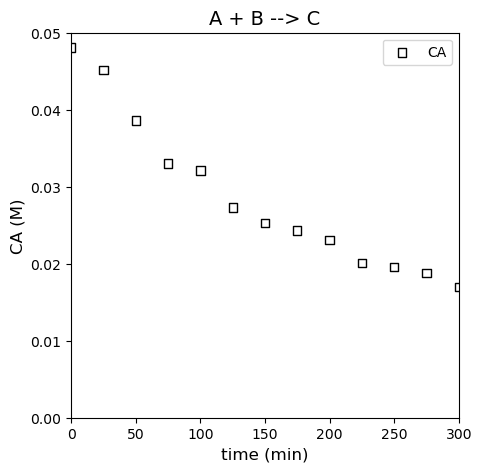

In [2]:
##########################################################################################################
# Store experimental time and concentration data in numpy arrays                                         #
##########################################################################################################

tdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
tDATA = tdata
tfine = np.linspace(0, max(tdata), 100)
CAdata =np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170]) #Concentrations in moles per liter
CADATA = CAdata

##########################################################################################################
# Create scatterplot to visualize CA vs. t shape/profile/time scale                                      #
##########################################################################################################

plt.figure(figsize = (5, 5))
plt.title('A + B --> C', fontsize = 14)
plt.scatter(tdata, CAdata, marker = 's', color = 'none', edgecolor = 'black', label = 'CA')
plt.ylim(0, 0.05)
plt.xlim(0, 300)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.legend()
plt.show()

Now we begin the analyis of this data in our attempt to extract the rate constant, $k$, and the reaction order in $A$, $\alpha$. We are working with a power law model that includes a lumped rate constant:

$$r = k^\prime{C_A}^\alpha$$

Recall that our data set comprises the concentration of species $A$ measured at various points in time. It is fundamentally a $C_A$ vs. $t$ data set. Our rate law is a model that describes how $r$ changes as a function of $C_A$, but we have no data (yet) where rates are measured as a function of $C_A$. We can begin to describe the relationship between $C_A$ and $t$ by writing a material balance on species $A$. For a constant volume batch reactor, the balance on species $A$ is:

$$\frac{dC_A}{dt} = R_A$$

Here, we have a single reaction where the production rate of $A$ is $R_A = -r$:

$$\frac{dC_A}{dt} = -r$$

Finally, we can substitute the lumped power law rate expression to get:

$$\frac{dC_A}{dt} = -k^\prime{C_A}^\alpha$$

Now we have a differential equation that we can use to either

1. Relate $r$ to $C_A$ using a differential analysis.
2. Relate $C_A$ to $t$ using integral analysis. 

We might recall that a differential analysis is fast and easy to apply -- a major reason for this is that it does not require us to assume a reaction order and solve the resultant differential equation. Differential analysis is generally useful when we have an unknown reaction order, as is the case here.  For these reasons, it makes sense to start with a differential analysis. This will give us some idea of the reaction order and rate constant, and then we can proceed to an integral analysis to improve precision in our parameter estimates.

### Differential Analysis

The beauty of the differential analysis is that we can use it to estimate the reaction order when we really don't know one. We should be aware that a differential analysis of data can introduce imprecision and amplify noise because of limitations in finite difference approximations, but it remains a useful way to start our analysis. 

From our material balance, we know that, in a constant volume batch reactor, the reaction rate can be inferred from the time derivative of species concentration. For example, the balance on species A tells us:

$$\frac{dC_A}{dt} = -r$$

In other words, if we can calculate the time derivative of concentration of $A$, $dC_A/dt$, we would essentially be calculating the reaction rate. We have discrete data, not a $C_A(t)$ function, so we cannot take an analytical derivative; however, we can proceed as we did in [Notebook 40](https://jqbond.github.io/CEN587/Notebooks/587-N40.html) by approximating the time derivative of $C_A$ using a forward difference approximation.

$$\frac{dC_A}{dt}\bigg|_{C_{A_n}} \approx \frac{C_{A_{n+1}} - C_{A_{n}}}{t_{n+1} - t_n}$$

This approximation gives us a set of approximate reaction rate estimated at a corresponding set of $C_A$ values. This is enough information for us to begin testing the relationship between reaction rate and concentration of $A$. Starting with the proposed rate law:

$$r = k^{\prime}{C_A}^\alpha$$

Which can be linearized using logarithms:

$$\ln(r) = \ln(k^\prime) + \alpha \ln(C_A)$$

We can use this first order model to regress coefficients (slope and y-intercept), which inform us about the reaction order and rate constant.

```{caution}
Recall that we have to use two data points to estimate a derivative, so our set of 13 measurments gives us 12 estimated derivatives using a forward difference method only. Now let's plot those rates against the corresponding concentrations on logarithmic axes to get a sense of the reaction order...
```

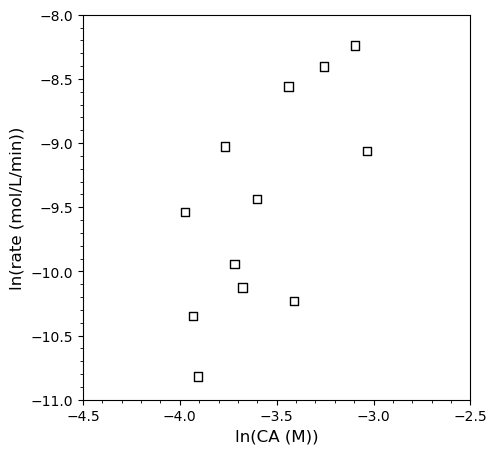

In [3]:
###################################################################################################
# Calculate finite differences in CA and t; use to estimate rate of reaction                      #
###################################################################################################

ΔCA = np.diff(CAdata)
Δt  = np.diff(tdata)
r   = -1*ΔCA/Δt
# print(len(CAdata))
# print(len(r))

##################################################################################################
# Define ydata and xdata for linearized power law expression                                     #
##################################################################################################

ydata = np.log(r)
xdata = np.log(CAdata[:-1])

##################################################################################################
# Create a scatterplot of ydata vs xdata to assess linearity                                     #
##################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 's', color = 'none', edgecolor = 'black', label = 'CA')
plt.xlabel('ln(CA (M))', fontsize = 12)
plt.ylabel('ln(rate (mol/L/min))', fontsize = 12)
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.show()

Yikes! It's really hard to say whether that trend is linear. Let's work through the linear regression analysis and calculation of statistical metrics to get a quantitative sense of the fit as well as the reaction order and rate constant suggested by differential analysis. 

m    = 1.75 +/- 1.35
b    = -3.22 +/- 4.85
SSE  = 4.19
SST  = 7.68
MSE  = 0.35
RMSE = 0.59
R2   = 0.45
α    = 1.75 +/- 1.35
k    = 0.04 (but really is between 3.12e-04 and 5.11e+00)
F0   = 8.32
fval = 4.96
pval = 0.02


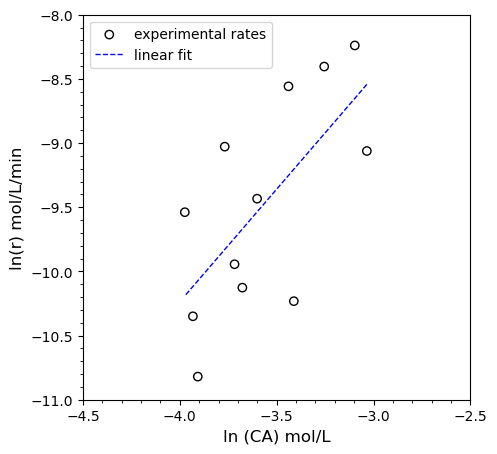

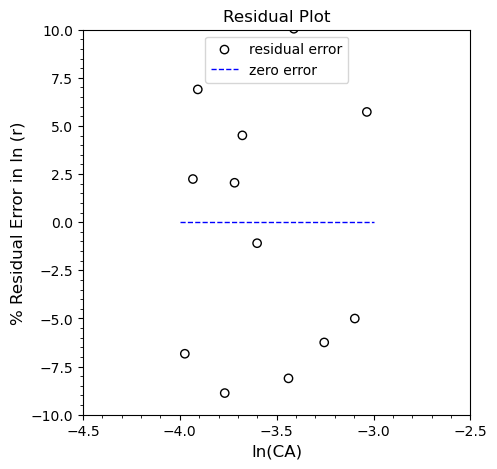

In [4]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(r)
xdata = np.log(CAdata[:-1])

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
SSR    = np.sum((Ypred - Ybar)**2)    #Regression sum of squares --> F0
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
MSERR  = SSE1/DOF
MSREG  = SSR/(len(A) - 1)
F0     = MSREG/MSERR
fval   = stats.f.ppf(0.95, len(A) - 1, DOF)
pval   = 1 - stats.f.cdf(F0, len(A) - 1, DOF) 
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order α
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k', 'F0', 'fval', 'pval']
values = [m  ,  b ,  SSE1 ,  SST , MSE , RMSE ,  R2, α, k, F0, fval, pval]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIb:0.2f}')
    elif label == 'α':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2f} (but really is between {np.exp(b-CIb):0.2e} and {np.exp(b+CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.xlabel('ln (CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/min', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-10, 10)
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

Clearly, this is a pretty rough fit to noisy data -- the coefficient of determination is far from 1 $(R^2 = 0.45)$, and we see large confidence intervals on the parameter estimates. That said, the measurements do scatter uniformly around the prediction line, and the absolute residual errors are not terrible. Although we don't have high confidence in any parameter, the data fit suggests that the reaction order is $\alpha = 1.75 \pm 1.3$ and that the rate constant is $k = 0.04$ with large confidence intervals. 

Let's see if we can do a little better -- it helps if we understand the origin(s) of imprecision here. First, as we saw in [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), taking finite differences introduces imprecision -- even in perfect data.  Here, we have real (simulated real) data, where there is actual uncertainty and noise in the measurements. Sometimes our measurements are higher or lower than the "true" value at that time, and this compounds the uncertainty in the approximation that derivatives are constant when we use finite difference approximations.

We can do a little better if we smooth the data before we estimate the derivative of that data. One way that we can do this is regressing a polynomial that captures the behavior of the data set ($C_A$ vs. $t$), but excludes the noise in the data set. Before we proceed, we should recognize that this polynomial fit is meaningless in a physical sense. It will do an adequate job of describing how $C_A$ changes as a function of $t$, but it does not contain any physical insight into the system, and it has no relation to the material balance on a batch reactor. It is simply a way for us to develop a continuous, well-behaved function that empirically captures how concentration decreases with time. Once we have this regression polynomial, it is a well-defined $C_A(t)$ function, which means we can take an analytical derivative instead of using finite differences to approximate derivatives. We can then use this analytical derivative to estimate rate of reaction and thus reaction orders.  

First, we need to fit a polynomial to data. We have options for doing this, but they are all an implementation of linear least squares as discussed in [Notebook 37](https://jqbond.github.io/CEN587/Notebooks/587-N37.html). For convenience, we will use `numpy.polyfit()` here. We do not have a good sense of the order of the polynomial that we should use at the start of the regession analysis, and it is easy to adjust this value with `numpy.polyfit()`.

We have 13 data points, which means we ***could*** fit up to a 12th order polynomial. We can test a few possibilities between first order and fifth order, and we find that a third order polynomial does a good job of smoothly capturing the overall trend in data without fitting the noise, so we'll use that to provide a polynomial approximation of how concentration changes with time.

[-9.30536131e-10  7.46493506e-07 -2.46443390e-04  4.90969780e-02]


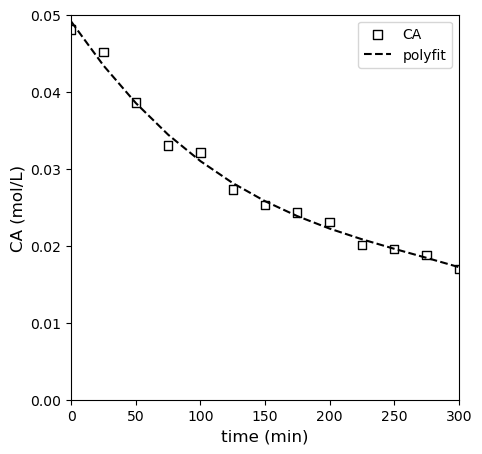

In [5]:
############################################################################################
# Fit a 3rd order polynomial to CA vs t using np.polyfit()                                 #
# np.polyfit() returns an array of coefficients describing the polynomial                  #
############################################################################################

A      = np.polyfit(tdata, CAdata, 3)
print(A)

############################################################################################
# We can pass the array of coefficients to np.polyval(A, t)                                #
# This evaluates the polynomial approximation for CA(t) at times specified by 2nd arg      #
############################################################################################

CApoly = np.polyval(A, tdata)

############################################################################################
# Overlay regressed polynomial with data; you can see that it describes trend w/o noise    #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, marker = 's', color = 'none', edgecolor = 'black', label = 'CA')
plt.plot(tdata, CApoly, color = 'black', linestyle = 'dashed', label = 'polyfit')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.ylim(0, 0.05)
plt.xlim(0, 300)
plt.legend()
plt.show()

Similar to `numpy.polyval()`, there are nice tools in `numpy` that we can use once we have polynomial coefficients. For example, `numpy.polyder(A, m)` will calculate the analytical derivative of the polynomimal defined by the coefficients in `A`. The order of the derivative (first derivative, second derivative, etc.) is specified by the second argument, `m`. 

```{important}
Remember: the time derivative of $C_A$ is equal to $-r$.
```

In [6]:
#################################################################################################################
# print the array of coefficients generated by numpy.polyder(); order of t is implied by number of coefficients #
# Here we have 4 coefficients, which means we have a 3rd order polynomial                                       #
# The first coefficient is multiplied by the highest order, the second coefficient by the second highest order  #
# This pattern proceeds until the last coefficient, which is multiplied by t^0                                  #
################################################################################################################# 

print(A)

#################################################################################################################
# The next line prints the coefficients of the analytical derivative of the 3rd order polynomial                #
#################################################################################################################

print(f'[{3*A[0]:15.8E} {2*A[1]:15.8E} {1*A[2]:15.8E} {0*A[3]:15.8E}')#, ' ', 2*A[1], ' ', 1*A[2], 0*A[3])

#################################################################################################################
# Next line prints the coefficients of the derivative of the 3rd order polynomial calculated by numpy.polyder() #
#################################################################################################################

print(np.polyder(A, m = 1)) #should be identical to those calculated by us above

#################################################################################################################
# Store the coefficients in a new array -- they themselves define a 2nd order polynomial that describes dCAdt   #
#################################################################################################################

derivatives    = np.polyder(A, m = 1)

#################################################################################################################
# Evaluate the derivative at time points in tdata; these are estimates of the rate of reaction at each t        #
#################################################################################################################

rate_estimates = -1*np.polyval(derivatives, tdata)

[-9.30536131e-10  7.46493506e-07 -2.46443390e-04  4.90969780e-02]
[-2.79160839E-09  1.49298701E-06 -2.46443390E-04  0.00000000E+00
[-2.79160839e-09  1.49298701e-06 -2.46443390e-04]


Now that we have estimated the rates by taking a derivative of the polynomial approximation, let's try our linearization and regression again.

m    = 1.75 +/- 0.20
b    = -2.99 +/- 0.72
SSE  = 0.12
SST  = 4.30
MSE  = 0.01
RMSE = 0.10
R2   = 0.97
α    = 1.75 +/- 0.20
k    = 0.05 (but really is between 2.45e-02 and 1.03e-01)


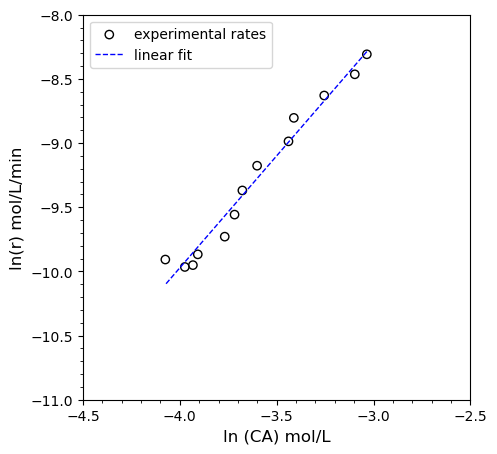

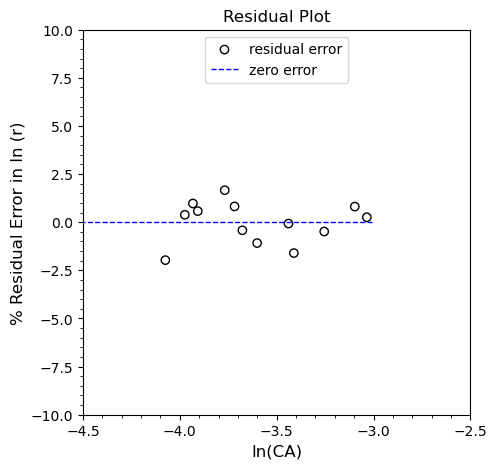

In [7]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(rate_estimates)
xdata = np.log(CAdata) #we did not use finite differences, so there is 1 rate estimate at each CA

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order α
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1 ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIb:0.2f}')
    elif label == 'α':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2f} (but really is between {np.exp(b-CIb):0.2e} and {np.exp(b+CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.xlabel('ln (CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/min', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-10, 10)
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

The estimates of our order and rate constant didn't change too much, but their precision has improved. It is easier to accept the trend we see here because the fit is so much better.This increases our confidence in the value of each estimate. Based on this revised analysis, we conclude that the reaction order is:

$$\alpha = 1.8 \pm 0.2$$

If we are restricting ourselves to integer orders (as suggested in the problem statement), we would probably conclude that the rate of reaction is $2^{nd}$ order in $A$. We also would estimate the lumped rate constant from the value of the y-intercept and conclude that it is

$k^\prime = 0.05 \ \mathrm{L \ mol^{-1} \ min^{-1}}$ 

We have transformed confidence intervals on the y-intercept to an upper bound and lower bound on the rate constant, and a more accurate statement would be that the lumped rate constant is  somewhere between 0.02 and 0.1 L/mol/min. This provides us with a solid foundation and some expectations about parameter estimates, even if they are not extremely precise. Next, we will work through integral analysis (mindful of these insights) and see if our conclusions hold.

### Integral Analysis with nonlinear Regression

We'll start with the balance

$$\frac{dC_A}{dt} = -k^\prime{C_A}^\alpha$$

And we'll guess integer orders for $\alpha$ and see what shakes out.  I'm going to try $\alpha$ = 1, 2, and 3 in this example.

#### First Order Solution

For a first order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k^\prime C_A$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{C_A}dC_A = \int_0^t-k^\prime dt$$

Which gives:

$$C_A = C_{A0}\exp\left(-k^\prime t\right)$$

#### Second Order Solution

For a second order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k^\prime {C_A}^2$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^2}dC_A = \int_0^t-k^\prime dt$$

Which gives:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$$

We can rearrange to get:

$$C_A = \left(\frac{1}{C_{A0}} + k^\prime t\right)^{-1}$$

#### Third Order Solution

For a third order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k^\prime {C_A}^3$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^3}dC_A = \int_0^t-k^\prime dt$$

Which gives:

$$\frac{1}{{C_A}^2} = \frac{1}{{C_{A0}}^2} + 2k^\prime t$$

We can rearrange to get:

$$C_A = \left(\frac{1}{{C_{A0}}^2} + 2k^\prime t\right)^{-\frac{1}{2}}$$

#### Summary of integrated models

To summarize, we have 3 models to compare to our data:

**First Order**: $C_A = C_{A0}\exp\left(-k^\prime t\right)$

**Second Order**: $\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$

**Third Order**: $C_A = \left(\frac{1}{{C_{A0}}^2} + 2k^\prime t\right)^{-\frac{1}{2}}$

Now let's overlay those models with our data and run an optimization (nonlinear least squares) to find the best value of the lumped rate constant.  Then, we'll take a look at how well the model fits our data.

In [8]:
#############################################################################################
# The initial concentrations are well-defined and can be set as global constants            #
#############################################################################################

CA0   = 0.05 #mol/L

#############################################################################################
# Define CA vs t model for first order kinetics                                             #
#############################################################################################
CAONE = lambda k1, t: CA0*np.exp(-k1*t)

#############################################################################################
# Define CA vs t model for second order kinetics                                            #
#############################################################################################

CATWO = lambda k2, t: 1/(1/CA0 + k2*t)

#############################################################################################
# Define CA vs t model for third order kinetics                                             #
#############################################################################################

CATHREE = lambda k3, t: np.sqrt(1/(1/CA0**2 + 2*k3*t))

### Nonlinear Least Squares

As we considered in L29, the mathematically rigorous way to find the best value of the rate constant is to find the one that gives the "line of best fit" by minimizing the residual sum of squares:

$$SSE = \sum_i \left(y_i - \hat{y}_i\right)^2$$

Mean square error is defined as:

$$MSE = \frac{1}{N}\sum_i (y_i - \hat{y}_i)^2$$

It allows us to normalize error to the number of measurments made. The root mean square is defined as:

$$RMSE = \sqrt{\frac{1}{N}\sum_i (y_i - \hat{y}_i)^2}$$

And the Mean Absolute Error is defined as:

$$MAE = \frac{1}{N}\sum_i |y_i - \hat{y}_i|$$

In addition to the SSE, we can also calculate the total sum of squares:

$$SST = \sum_i \left(y_i - \bar{y}_i\right)^2$$

This can be used to get a coefficient of determination:

$$R^2 = 1 - \frac{SSE}{SST}$$

If you want to obtain estimates of standard error in the slope and y intercept that you regress, you need to estimate the covariance matrix.  First, we estimate the variance, $\sigma^2$ with the following:

$$\sigma^2 \approx s^2$$

and:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Where $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters.  This is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

With that, we can estimate the covariance matrix from the Jacobian Matrix:

$$COV = s^2(J'J)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

Noting that this may throw a warning if off-diagonal elements of the covariance matrix are negative.

From that, we get the standard error in our parameter values from the diagonal elements.

If you want to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

### First Order Nonlinear Regression

In [9]:
def OBJONE(k1):
    CAMOD   = CAONE(k1, tDATA)
    RESID   = CADATA - CAMOD
    SSE     = np.sum(RESID**2)
    return SSE

def JACONE(k1):
    JAC     = -CA0*tDATA*np.exp(- k1*tDATA)
    return JAC


k =  4.10E-03, SSE = 5.00E-05
k    = 4.10E-03 +/- 3.40E-04
SSE  = 5.00E-05
MSE  = 3.85E-06
RMSE = 1.96E-03
MAE  = 1.65E-03
R2   = 9.59E-01


C:\Users\jqbon\AppData\Local\Temp\ipykernel_13776\669969681.py:4: RuntimeWarning: overflow encountered in square
  SSE     = np.sum(RESID**2)


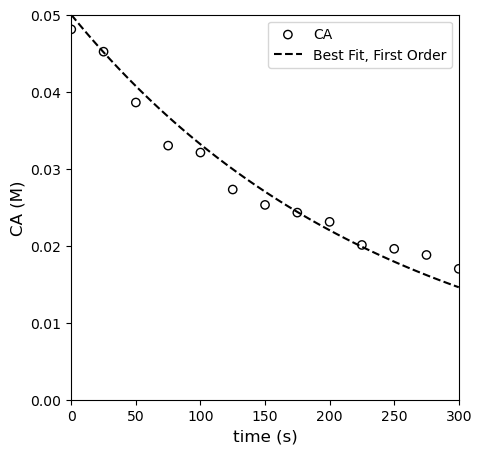

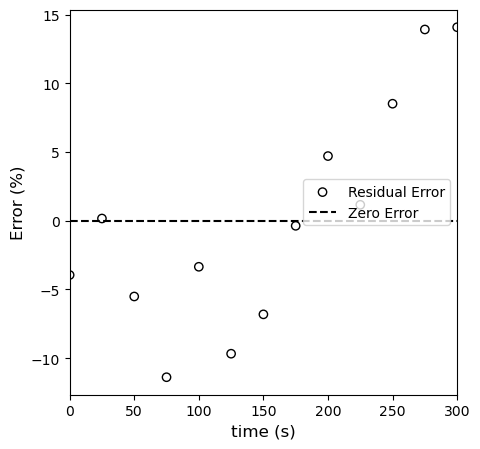

In [10]:
#############################################################################################
# Find the value of k1 that minimizes the objective function using opt.minimize_scalar()    #
#############################################################################################

ans_one = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 10])

#############################################################################################
# the .fun field in the solution structure is the minimum value of the objective function   #
#############################################################################################

SSE1 = ans_one.fun

#############################################################################################
# the .x field in the solution structure is the value of k that minimizes the obj function  #
#############################################################################################

k_one = ans_one.x
k1   = k_one

#############################################################################################
# print the optimum k1 and SSE                                                              #
#############################################################################################

print(f'\nk = {k_one:9.2E}, SSE = {SSE1:7.2E}')

#############################################################################################
# Pass optimum rate constant to a 1st order model to generate CA_pred at tdata values       #
#############################################################################################

CAPREDONE = CAONE(k_one, tdata)

#############################################################################################
# Calculate Jacobian for confidence interval calculations                                   #
#############################################################################################

JAC1      = JACONE(k_one)

#############################################################################################
# Statistics                                                                                #
#############################################################################################

Ndata     = len(tdata)
CAbar     = np.mean(CAdata)
SST1      = np.sum((CAdata - CAbar)**2)
MSE1      = SSE1/Ndata
RMSE1     = np.sqrt(MSE1)
MAE1      = 1/Ndata*np.sum(np.abs(CAdata - CAPREDONE))
R21       = 1 - SSE1/SST1
DOF       = Ndata - 1
s2        = SSE1/DOF                     #Estimate variance
COV1      = SSE1/DOF*1/(JAC1.T@JAC1)
SEk1      = np.sqrt(COV1) 
tval      = stats.t.ppf(0.975, DOF)
CIk1      = tval*SEk1

labels = ['k', 'SSE', 'MSE', 'RMSE', 'MAE', 'R2']
values = [k1, SSE1, MSE1, RMSE1, MAE1, R21]

for label, value in zip(labels, values):
    if label == 'k':
        print(f'{label:4s} = {value:0.2E} +/- {CIk1:0.2E}')
    else:
        print(f'{label:4s} = {value:0.2E}')


#############################################################################################
# Overlay best fit model with data                                                          #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tfine, CAONE(k_one, tfine), color = 'black', linestyle = 'dashed', label = 'Best Fit, First Order')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(0, 0.05)
plt.legend()
plt.show()

#############################################################################################
# Generate plot of residual errors -- calculate residuals as percent error                  #
# Converting the error to a percentage is not necessary                                     #
# I chose to convert to a percentage so that residuals for all models are on same y-scale   #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPREDONE)/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 300)
plt.legend(loc = 'right')
plt.show()

Now we have some quantitative assessments of goodness of fit.  For real data, an $R^2$ of 0.96 or so is pretty good, so for the moment, we'll call this an acceptable fit.

### Second Order Nonlinear Regression

Now let's see how a second order model fits the data.  We'll go ahead and regress the best fit rate constant, plot the result, and calculate some basic statistical data about goodness of fit.

In [11]:
def OBJTWO(k2):
    CAMOD   = CATWO(k2, tDATA)
    RESID    = CADATA - CAMOD
    SSE      = np.sum(RESID**2)
    return SSE

def JACTWO(k2):     
    JAC     = -tdata/(1/CA0 + k2*tdata)**2
    return JAC


k =  1.24E-01, SSE = 1.30E-05
k    = 1.24E-01 +/- 7.16E-03
SSE  = 1.30E-05
MSE  = 1.00E-06
RMSE = 1.00E-03
MAE  = 8.29E-04
R2   = 9.89E-01


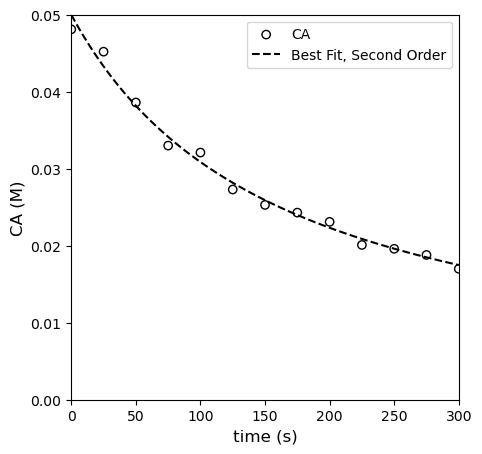

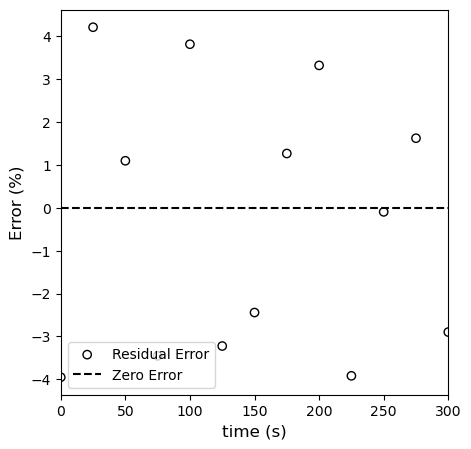

In [12]:
#############################################################################################
# Find the value of k2 that minimizes the OBJTWO using opt.minimize_scalar()                #
#############################################################################################

ans_two = opt.minimize_scalar(OBJTWO)#, method = 'Brent', bracket = [0.01, 10])

#############################################################################################
# the .fun field in the solution structure is the minimum value of the objective function   #
#############################################################################################

SSE2     = ans_two.fun

#############################################################################################
# the .x field in the solution structure is the value of k that minimizes the obj function  #
#############################################################################################

k_two   = ans_two.x
k2 = k_two

#############################################################################################
# print the optimum k2 and SSE                                                              #
#############################################################################################

print(f'\nk = {k_two:9.2E}, SSE = {SSE2:7.2E}')

#############################################################################################
# Pass optimum rate constant to a 2nd order model to generate CA_pred at tdata values       #
#############################################################################################

CAPREDTWO = CATWO(k_two, tdata)

#############################################################################################
# Calculate Jacobian for confidence interval calculations                                   #
#############################################################################################

JAC2      = JACTWO(k_two)

#############################################################################################
# Statistics                                                                                #
#############################################################################################

Ndata     = len(tdata)
CAbar     = np.mean(CAdata)
SST2      = np.sum((CAdata - CAbar)**2)
MSE2      = SSE2/Ndata
RMSE2     = np.sqrt(MSE2)
MAE2      = 1/Ndata*np.sum(np.abs(CAdata - CAPREDTWO))
R22       = 1 - SSE2/SST2
DOF       = Ndata - 1
s2        = SSE2/DOF                     #Estimate variance
COV2      = SSE2/DOF*1/(JAC2.T@JAC2)
SEk2      = np.sqrt(COV2) 
tval      = stats.t.ppf(0.975, DOF)
CIk2      = tval*SEk2

labels = ['k', 'SSE', 'MSE', 'RMSE', 'MAE', 'R2']
values = [k2, SSE2, MSE2, RMSE2, MAE2, R22]

for label, value in zip(labels, values):
    if label == 'k':
        print(f'{label:4s} = {value:0.2E} +/- {CIk2:0.2E}')
    else:
        print(f'{label:4s} = {value:0.2E}')

#############################################################################################
# Overlay best fit model with data                                                          #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tfine, CATWO(k_two, tfine), color = 'black', linestyle = 'dashed', label = 'Best Fit, Second Order')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(0, 0.05)
plt.legend()
plt.show()

#############################################################################################
# Generate plot of residual errors -- calculate residuals as percent error                  #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPREDTWO)/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 300)
plt.legend(loc = 'lower left')
plt.show()

OK, by all metrics--visual, SSE, and $R^2$, the second order model improves on the first order model.  Is it the best?  It's hard to say for sure...let's try the third order model and see how that goes.

In [13]:
def OBJTHREE(k3):
    CAMOD    = CATHREE(k3, tDATA)
    RESID    = CADATA - CAMOD
    SSE      = np.sum(RESID**2)
    return SSE

def JACTHREE(k3):            
    JAC     = (1/(1/CA0**2 + 2*k3*tdata))**(-1/2) * -tdata/(1/CA0**2 + 2*k3*tdata)**2
    return JAC


k =  3.67E+00, SSE = 4.62E-05
k    = 3.67E+00 +/- 5.10E-01
SSE  = 4.62E-05
MSE  = 3.55E-06
RMSE = 1.88E-03
MAE  = 1.52E-03
R2   = 9.63E-01


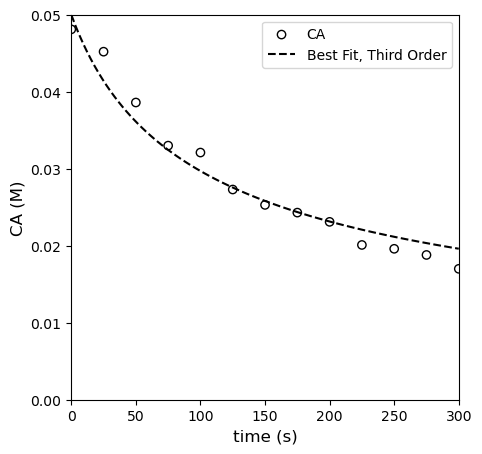

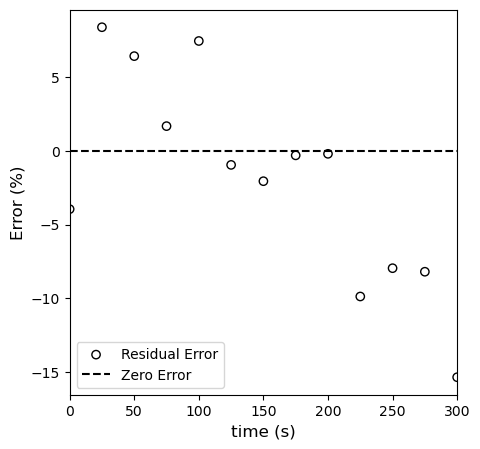

In [14]:
#############################################################################################
# Find the value of k3 that minimizes the OBJTHREE using opt.minimize_scalar()              #
#############################################################################################

ans_three = opt.minimize_scalar(OBJTHREE)# Test this; it will throw a warning and not find an optiumum
# ans_three = opt.minimize_scalar(OBJTHREE, method = 'Bounded', bounds = [0.00001, 1])

#############################################################################################
# the .fun field in the solution structure is the minimum value of the objective function   #
#############################################################################################

SSE3      = ans_three.fun

#############################################################################################
# the .x field in the solution structure is the value of k that minimizes the obj function  #
#############################################################################################

k_three   = ans_three.x
k3 = k_three

#############################################################################################
# print the optimum k3 and SSE                                                              #
#############################################################################################

print(f'\nk = {k_three:9.2E}, SSE = {SSE3:7.2E}')

#############################################################################################
# Pass optimum rate constant to a 2nd order model to generate CA_pred at tdata values       #
#############################################################################################

CAPREDTHREE = CATHREE(k_three, tdata)

#############################################################################################
# Calculate Jacobian for confidence interval calculations                                   #
#############################################################################################

JAC3      = JACTHREE(k_three)

#############################################################################################
# Statistics                                                                                #
#############################################################################################

Ndata     = len(tdata)
CAbar     = np.mean(CAdata)
SST3      = np.sum((CAdata - CAbar)**2)
MSE3      = SSE3/Ndata
RMSE3     = np.sqrt(MSE3)
MAE3      = 1/Ndata*np.sum(np.abs(CAdata - CAPREDTHREE))
R23       = 1 - SSE3/SST3
DOF       = Ndata - 1
s2        = SSE3/DOF                     #Estimate variance
COV3      = SSE3/DOF*1/(JAC3.T@JAC3)
SEk3      = np.sqrt(COV3) 
tval      = stats.t.ppf(0.975, DOF)
CIk3      = tval*SEk3

labels = ['k', 'SSE', 'MSE', 'RMSE', 'MAE', 'R2']
values = [k3, SSE3, MSE3, RMSE3, MAE3, R23]

for label, value in zip(labels, values):
    if label == 'k':
        print(f'{label:4s} = {value:0.2E} +/- {CIk3:0.2E}')
    else:
        print(f'{label:4s} = {value:0.2E}')

#############################################################################################
# Overlay best fit model with data                                                          #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tfine, CATHREE(k_three, tfine), color = 'black', linestyle = 'dashed', label = 'Best Fit, Third Order')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(0, 0.05)
plt.legend()
plt.show()

#############################################################################################
# Generate plot of residual errors -- calculate residuals as percent error                  #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPREDTHREE)/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 300)
plt.legend(loc = 'lower left')
plt.show()

Alright...looks like we've gone a little too far.  The third order model is slightly better than the first order model and slightly worse than the second order model.  Any of them probably do an OK job of fitting the data, but quantitatively, the second order model is probably just a bit better.  

As we discussed during Lecture 29, it can be really hard to tell whether or not a model is "correct" just by visual inspection.  All of the above, in isolation, seem to fit the data pretty well. We'll overlay all three where you can start to see that the second order model does the best.  Then, we'll look at linearized models if we can to see if we can see some deviation from linearity.

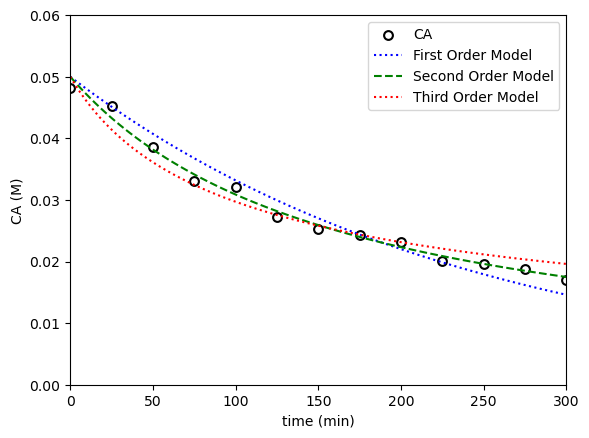

In [15]:
#Overlay best fit models with data
plt.scatter(tdata, CAdata, label = 'CA', color = 'white', edgecolor = 'black', linewidth = 1.5, s = 40)
plt.plot(tfine, CAONE(k1, tfine),  color = 'blue',  linewidth = 1.5, linestyle = 'dotted', label = 'First Order Model')
plt.plot(tfine, CATWO(k2, tfine), color = 'green', linewidth = 1.5, linestyle = 'dashed', label = 'Second Order Model')
plt.plot(tfine, CATHREE(k3, tfine),  color = 'red',   linewidth = 1.5, linestyle = 'dotted', label = 'Third Order Model')
plt.xlabel('time (min)')
plt.ylabel('CA (M)')
plt.ylim(0, 0.06)
plt.xlim(0, max(tdata))
plt.legend()
plt.show()

### Linearization of Data

#### First Order Linearization

For the first order model, we have:

$$C_A = C_{A0}\exp(-k^\prime t)$$

This is a nonlinear function of, essentially kt; however, if we take the natural logarithm of both sides, we convert it to the following, which is much more useful:

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - k^\prime t$$

If we plot $C_A$ against time, that should be linear if the first order model is correct.  The slope would be equal to -k, and the y-intercept would be ln(CA0).  

This is plotted in the cell below, where you observe linearity.

m    = -0.0034 +/- 0.0004
b    = -3.0924 +/- 0.0642
SSE  = 0.0340
SST  = 1.3711
MSE  = 0.0026
RMSE = 0.0512
R2   = 0.9752
k1   = 0.0034
CA0  = 0.0454


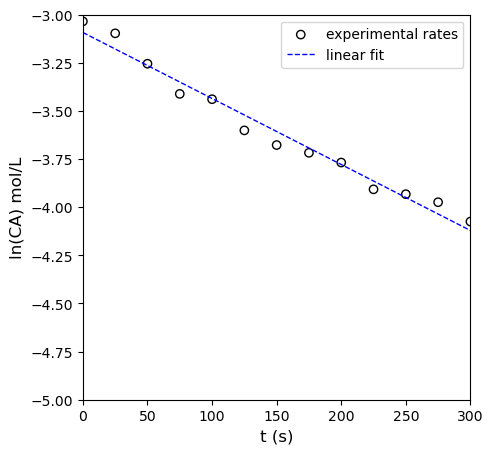

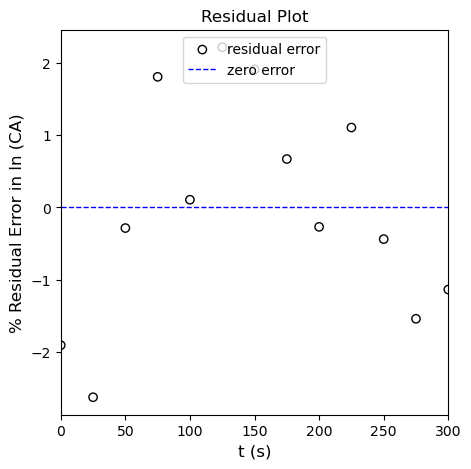

In [16]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(CAdata)
xdata = tdata

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
k1     = -1*m                         #slope is equal to the -k
CA0e   = np.exp(b)                    #y intercept is equal to ln(CA0)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k1', 'CA0']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, k1, CA0e]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4f} +/- {CIm:0.4f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4f} +/- {CIb:0.4f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 300)
plt.ylim(-5, -3)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('ln(CA) mol/L', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 300)
# plt.ylim(-0.08, 0.08)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (CA)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

**Second Order Model**

For the second order model, we have:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

We should see linearity here if we plot $\frac{1}{C_A}$ vs $t$.  See below; this model clearly shows less deviation from linearity than the first order linearization.

m    = 0.1255 +/- 0.0077
b    = 19.9145 +/- 1.3604
SSE  = 15.2968
SST  = 1807.5804
MSE  = 1.1767
RMSE = 1.0847
R2   = 0.9915
k2   = 1.2552E-01
CA0  = 0.0502


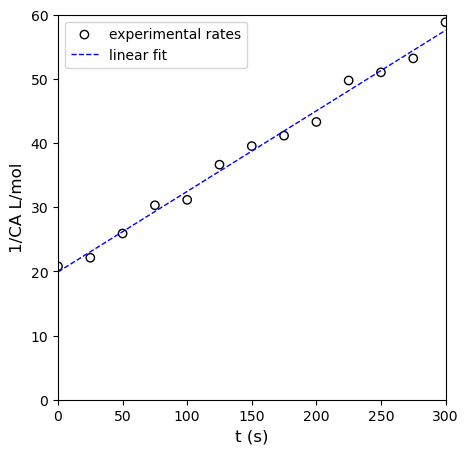

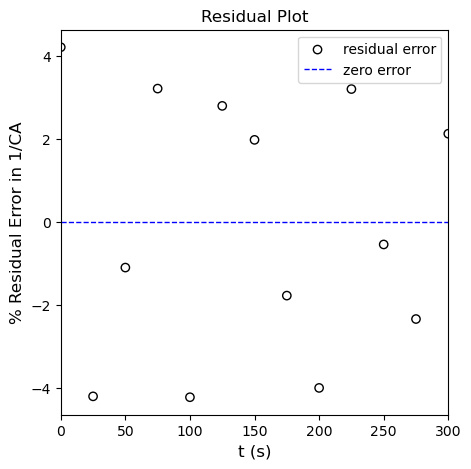

In [17]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = 1/CAdata
xdata = tdata

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
k2     = m                            #slope is equal to k
CA0e   = 1/b                          #y intercept is equal to 1/CA0

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k2', 'CA0']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, k2, CA0e]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4f} +/- {CIm:0.4f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4f} +/- {CIb:0.4f}')
    elif label == 'k2':
        print(f'{label:4s} = {value:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 300)
plt.ylim(0, 60)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/CA L/mol', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 300)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in 1/CA', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper right')
plt.show()

I like the second order fit!  I can see scatter around the line of best fit instead of a systematic deviation like in the first order model. Let's check the third order linearization just to see if the second order model still looks better.

For the third order model, we have a slightly different linearization that is based on this form of the integrated model:

$$\frac{1}{{C_A}^2} = \frac{1}{{C_{A0}}^2} + 2k^\prime t$$

If we plot $\frac{1}{{C_A}^2}$ vs time, we should see linearity if the third order model is correct.

m    = 4.8818E+00 +/- 5.8369E-01
b    = 8.7767E+01 +/- 1.0318E+02
SSE  = 87997.1295
SST  = 2798897.9361
MSE  = 6769.0100
RMSE = 82.2740
R2   = 0.9686
k3   = 4.8818E+00 +/- 5.8369E-01
CA0  = 0.0755


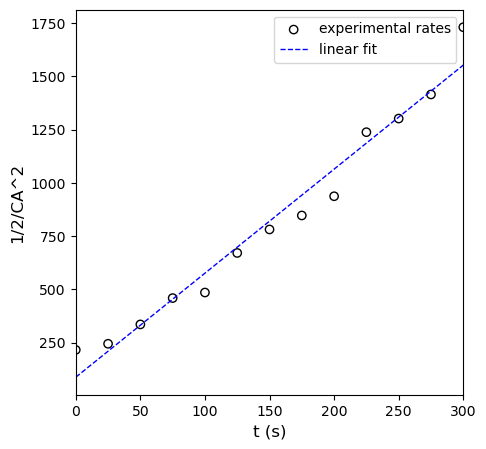

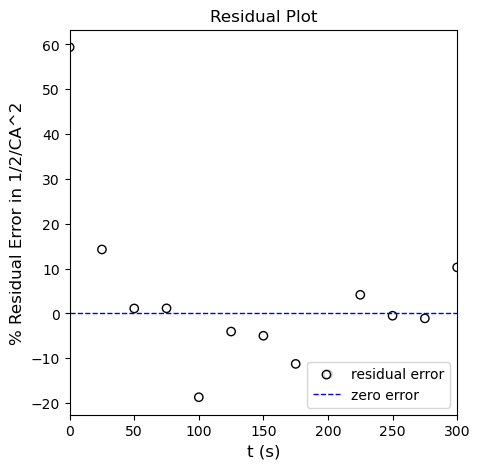

In [18]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = 1/2/CAdata**2
xdata = tdata

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
k3     = m                            #slope is equal to k
CIk3   = CIm                          #confidence interval on k3
CA0e   = np.sqrt(1/2/b)               #y intercept is equal to 1/2CA0^2

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k3', 'CA0']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, k3, CA0e]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4E} +/- {CIm:0.4E}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4E} +/- {CIb:0.4E}')
    elif label == 'k3':
        print(f'{label:4s} = {value:0.4E} +/- {CIk3:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 300)
# plt.ylim(0, 0.5)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/2/CA^2', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 300)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in 1/2/CA^2', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'lower right')
plt.show()

From everything we've done to this point, we can be fairly confident in concluding that our reaction is second order in species $A$, so our rate law is:

$$r = k^\prime {C_A}^2$$

Remember, way back when we started this problem, that we defined $k^\prime$ as a lumped rate constant:

$$k^\prime = kC_{B0}$$

We know that the starting concentration of $B$ in this system was $C_{B0} = 0.5 \ \mathrm{M}$, so we can calculate the true rate constant as:

$$k = \frac{k^\prime}{C_{B0}}$$

And our final rate law is:

$$r = k{C_A}^2{C_B}$$

In [19]:
print(f'Our most precise estimate of the lumped rate constant is {k2:3.3f} L/mol/min')
print(f'The true rate constant is {k2/0.5:3.3f} L^2 mol^-2 min^-1')

Our most precise estimate of the lumped rate constant is 0.126 L/mol/min
The true rate constant is 0.251 L^2 mol^-2 min^-1


### If Time Allows, we can come back to this point

Considering all of the analysis, the second order model seems to fit the data best.  Since we know that the initial value of $C_{A0}$ is 0.05M, we can improve our precision on the rate constant estimation slightly by choosing to not regress the y-intercept.  We can do that by rearranging our linearization slightly:

Instead of working with:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$$

And plotting $\frac{1}{C_A}$ vs. time, we will work with this form:

$$\frac{1}{C_A} - \frac{1}{C_{A0}} = k^\prime t$$

And we will plot $\frac{1}{C_A} - \frac{1}{C_{A0}}$ vs time. Alternatively, you could work with this form; either should give you a linear model with a zero y intercept:

$$\frac{(C_{A0} - C_A)}{C_{A0}C_A} = k^\prime t$$

I'll use the first form to construct the matrix form of our linear least squares problem:

$$\alpha_1t = \frac{1}{C_A} - \frac{1}{C_{A0}}$$

$$XA = Y$$

Where X is a vandermonde matrix created from tdata; however, we only keep the first order powers of time here (since there is no zero order coefficient in the model).  Y, in this case, is $\frac{1}{C_A} - \frac{1}{C_{A0}}$, and A is only a single coefficient, namely the slope of the line.  See below for implementation.  We can't use polyfit here, but if we know how to work with the vandermonde matrix, we have a lot of flexibility in regressions.  This is similar to what you can do with the LINEST function in Excel.

We'll leave the discussion of calculating standard error and confidence intervals for another day (or maybe explore sklearn utilities a bit).

m    = 1.2511E-01 +/- 3.8629E-03
b    = 8.7767E+01 +/- 1.0318E+02
SSE  = 15.3234
SST  = 1807.5804
MSE  = 1.1787
RMSE = 1.0857
R2   = 0.9915
k2   = 1.2511E-01 +/- 3.8629E-03


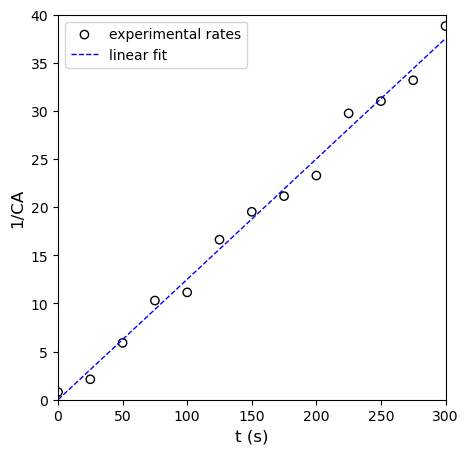

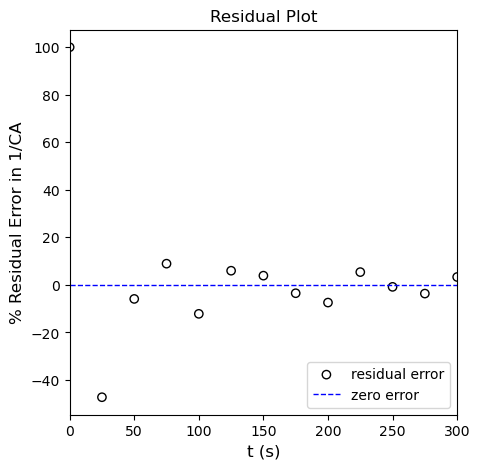

In [20]:
#####################################################################################################
# Make sure that we have the correct definition for CA0                                             #
#####################################################################################################

CA0   = 0.05 #M

#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = 1/CADATA - 1/CA0

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = tdata.reshape(len(tdata), 1)

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
k2b    = m                            #slope is equal to k
CIk2b  = CIm                          #Confidence interval on k3   

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'k2']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2 ,  k2b]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4E} +/- {CIm:0.4E}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4E} +/- {CIb:0.4E}')
    elif label == 'k2':
        print(f'{label:4s} = {value:0.4E} +/- {CIk2b:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 300)
plt.ylim(0, 40)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('1/CA', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 300)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in 1/CA', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'lower right')
plt.show()